# Rt Live Model

In [3]:
%load_ext autoreload
%autoreload 2

import pymc3 as pm
import pandas as pd
import numpy as np
import arviz as az
from matplotlib import pyplot as plt
from covid.models.generative import GenerativeModel
from covid.data import summarize_inference_data
%config InlineBackend.figure_format = 'retina'

from covid.data import get_and_process_covidtracking_data_il, summarize_inference_data

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Fetch data and select the state's data

In [4]:
df = get_and_process_covidtracking_data_il(run_date=pd.Timestamp.today()-pd.Timedelta(days=1))

In [5]:
region = "Israel"
model_data = df.loc[region]

## Create the model instance and sample

In [6]:
gm = GenerativeModel(region, model_data)
gm.sample()

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, seed, log_r_t]


Sampling 4 chains for 700 tune and 200 draw iterations (2_800 + 800 draws total) took 1986 seconds.


## Summarize Model Output

In [7]:
result = summarize_inference_data(gm.inference_data)

In [11]:
result.tail(30)

,mean,median,lower_80,upper_80,infections,test_adjusted_positive,test_adjusted_positive_raw,positive,tests
date,,,,,,,,,
2020-07-31,0.964963,0.964798,0.886777,1.028811,1049.668954,1231.087690,965.041041,1355,22140
2020-08-01,0.965711,0.965716,0.888671,1.030275,1042.138213,1229.643082,1329.726717,628,7447
2020-08-02,0.965637,0.965917,0.892387,1.029840,1034.757937,1227.138191,1179.972500,713,9528
2020-08-03,0.967595,0.968765,0.900097,1.047763,1027.565043,1223.693693,1255.061231,1804,22665
2020-08-04,0.969804,0.970185,0.888075,1.035672,1020.491680,1219.429376,1083.738680,1724,25084
2020-08-05,0.970094,0.973848,0.887473,1.034185,1013.658059,1214.464780,1070.978353,1691,24897
2020-08-06,0.972641,0.972007,0.897827,1.047068,1007.256456,1208.913533,948.846111,1677,27869
2020-08-07,0.973802,0.973925,0.891692,1.057088,1001.174683,1202.879514,1127.499630,1753,24516
2020-08-08,0.977281,0.976467,0.890149,1.057459,995.438818,1196.460674,1473.923370,762,8152


## Plot Model Output

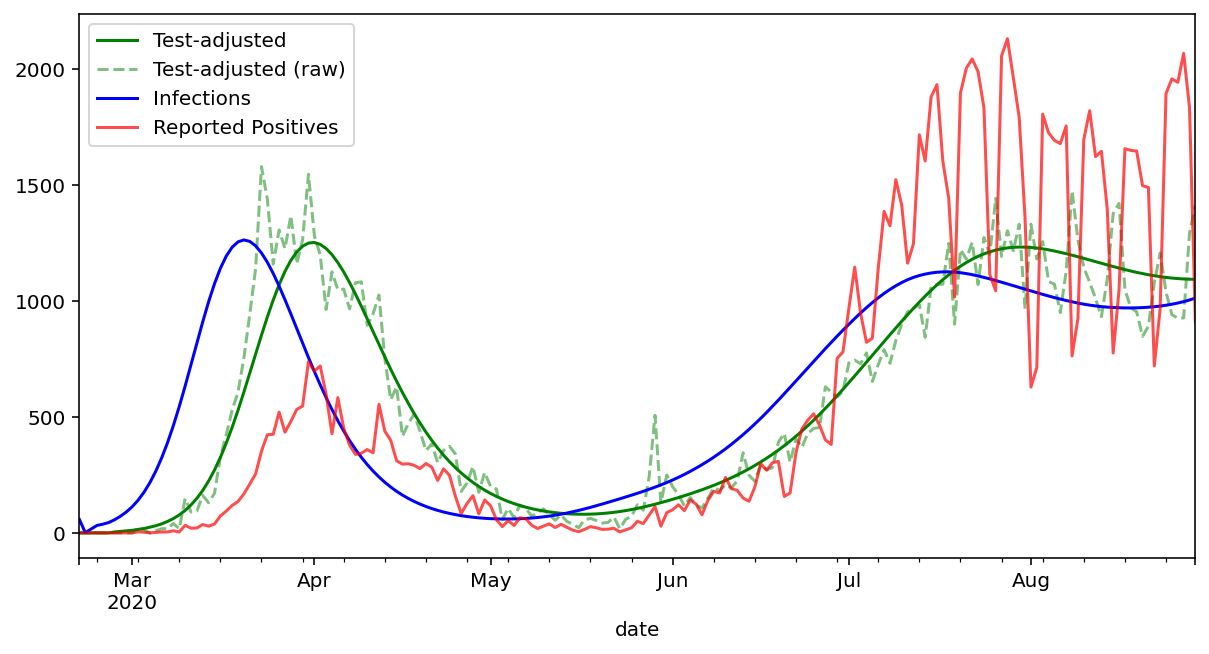

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
result.test_adjusted_positive.plot(c="g", label="Test-adjusted")
result.test_adjusted_positive_raw.plot(c="g", alpha=.5, label="Test-adjusted (raw)", style="--")
result.infections.plot(c="b", label="Infections")
gm.observed.positive.plot(c='r', alpha=.7, label="Reported Positives")
fig.set_facecolor('w')
ax.legend();

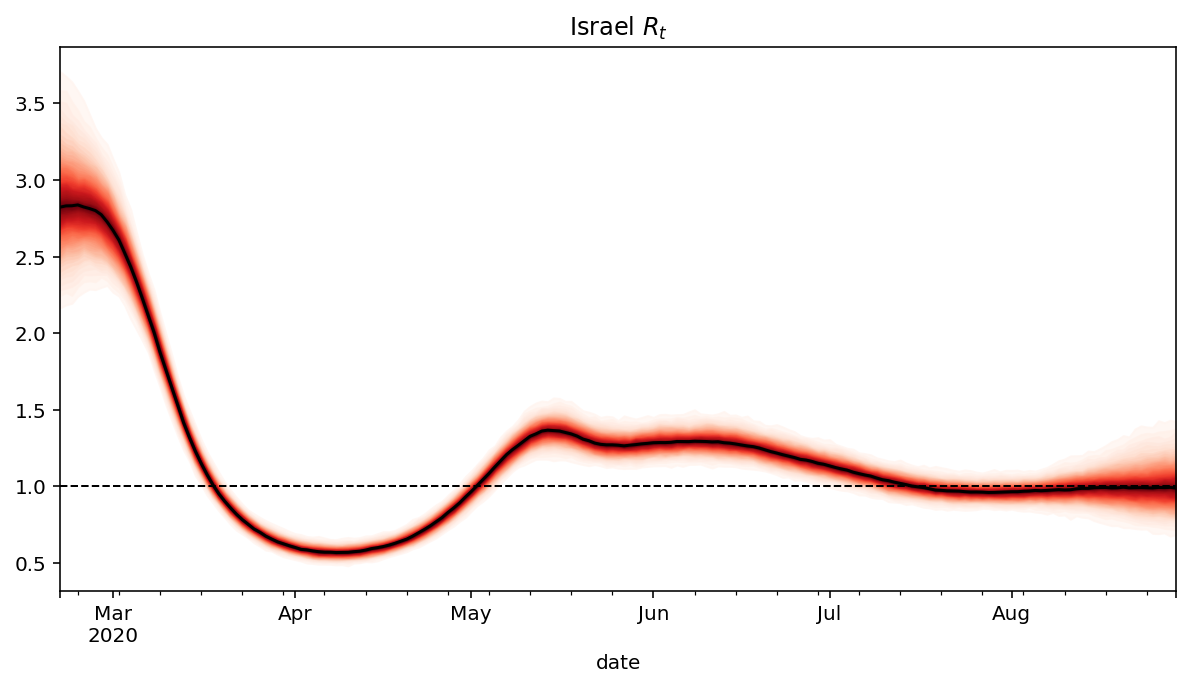

In [10]:
fig, ax = plt.subplots(figsize=(10,5))

ax.set_title(f"{region} $R_t$")
samples = gm.trace['r_t']
x=result.index
cmap = plt.get_cmap("Reds")
percs = np.linspace(51, 99, 40)
colors = (percs - np.min(percs)) / (np.max(percs) - np.min(percs))
samples = samples.T

result["median"].plot(c="k", ls='-')

for i, p in enumerate(percs[::-1]):
    upper = np.percentile(samples, p, axis=1)
    lower = np.percentile(samples, 100-p, axis=1)
    color_val = colors[i]
    ax.fill_between(x, upper, lower, color=cmap(color_val), alpha=.8)

ax.axhline(1.0, c="k", lw=1, linestyle="--")
fig.set_facecolor('w')